In [2]:
!pip install sexmachine


In [3]:
!pip install gender-guesser


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import gender_guesser.detector as gender


In [ ]:
# Load Dataset
def read_datasets():
    genuine_users = pd.read_csv("/content/drive/MyDrive/fake profiles/users.csv")
    fake_users = pd.read_csv("/content/drive/MyDrive/fake profiles/fusers.csv")

    x = pd.concat([genuine_users, fake_users])
    y = [0] * len(fake_users) + [1] * len(genuine_users)  # 0 -> Fake, 1 -> Genuine

    return x, y


In [ ]:
# Predict Gender from Name
def predict_sex(name_series):
    sex_predictor = gender.Detector(case_sensitive=False)

    def get_gender_from_name(name):
        if isinstance(name, str):
            first_name = name.split(' ')[0]
            return sex_predictor.get_gender(first_name)
        return 'unknown'

    sex = name_series.apply(get_gender_from_name)

    sex_dict = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'mostly_male': 1, 'male': 2, 'andy': 0}

    return sex.map(sex_dict).astype(int)


In [ ]:
# Extract Features for Model
def extract_features(x):
    lang_dict = {lang: idx for idx, lang in enumerate(x['lang'].unique())}

    x['lang_code'] = x['lang'].map(lang_dict).astype(int)
    x['sex_code'] = predict_sex(x['name'])

    selected_features = ['statuses_count', 'followers_count', 'friends_count',
                         'favourites_count', 'listed_count', 'sex_code', 'lang_code']

    return x[selected_features]


In [ ]:
# Train SVM Model
def train(X_train, y_train, X_test):
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': 10.0 ** np.arange(-2, 3, 0.5),
                  'gamma': 10.0 ** np.arange(-2, 3, 0.5)}

    cvk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(SVC(), param_grid, cv=cvk, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

    print("Best Parameters Found:", grid.best_params_)

    best_model = grid.best_estimator_

    scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)
    print(f"Cross-Validation Score: {scores.mean():.4f} (+/- {scores.std()/2:.4f})")

    plot_learning_curve(best_model, 'Learning Curve - SVM', X_train_scaled, y_train, cvk)

    y_pred = best_model.predict(X_test_scaled)

    return y_pred


In [ ]:
# Plot Learning Curve
def plot_learning_curve(estimator, title, X, y, cv):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1)

    plt.grid()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Validation Score")

    plt.legend(loc="best")
    plt.show()


In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Fake', 'Genuine'], rotation=45)
    plt.yticks(tick_marks, ['Fake', 'Genuine'])
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [ ]:
# Plot ROC Curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Loading Data
print("Loading Data...")
x, y = read_datasets()


Loading Data...


In [ ]:
# Extracting Features
print("Extracting Features...")
x = extract_features(x)
print(x.describe())


Extracting Features...
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.191270     0.556423  
std       23.480430     1.685612     0.562567  
min        0.000000    -2.000000     0.000000  
25%        0.000000    -2.000000     0.000000  
50%        0.

In [ ]:
# Splitting Data
print("Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)


Splitting Data...


Training SVM Model...
Best Parameters Found: {'C': 10.0, 'gamma': 1.0}
Cross-Validation Score: 0.9335 (+/- 0.0033)


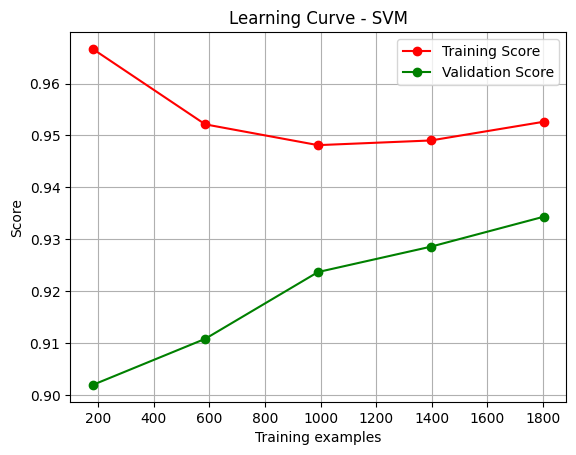

In [ ]:
# Training SVM Model
print("Training SVM Model...")
y_pred = train(X_train, y_train, X_test)


In [ ]:
# Evaluating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9131205673758865


Confusion Matrix:
 [[249  19]
 [ 30 266]]


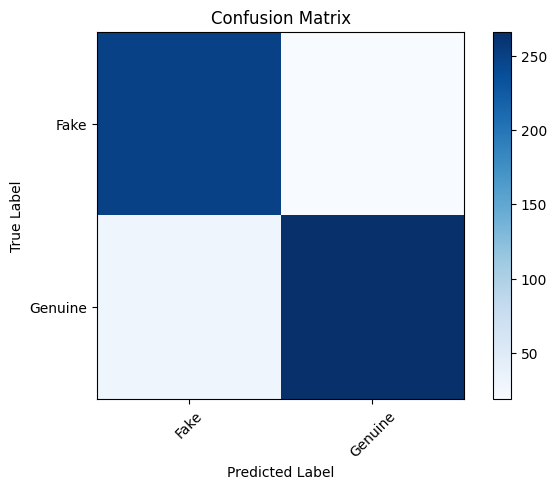

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
plot_confusion_matrix(cm)


In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Genuine']))


Classification Report:
               precision    recall  f1-score   support

        Fake       0.89      0.93      0.91       268
     Genuine       0.93      0.90      0.92       296

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



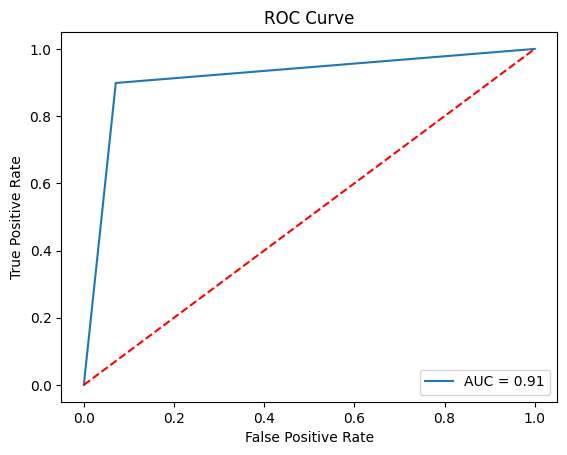

In [ ]:
# ROC Curve
plot_roc_curve(y_test, y_pred)
